## Import libraries

In [1]:
from importlib.metadata import version
import numpy as np

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
tiktoken version: 0.8.0
torch version: 2.5.1
tqdm version: 4.67.1
tensorflow version: 2.18.0


## Download dataset

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch" "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


## Format prompts

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [7]:
data[100]

{'instruction': 'Name a synonym for "happiness."',
 'input': '',
 'output': 'A synonym for "happiness" is "joy."'}

In [8]:
format_input(data[50])

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the correct spelling of the following word.\n\n### Input:\nOcassion'

## Split to train, val and test

In [9]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)  # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion : train_portion + test_portion]
val_data = data[train_portion + test_portion :]

In [10]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into batches

In [11]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


Create a collate function to handle adding extra tokens "endoftext"

In [13]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        #inputs = torch.tensor(padded)
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (inputs_1, inputs_2, inputs_3)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


Implement targets into collate function

In [15]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [16]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


Replace other endoftext tokens to be -100, so do not contribute to learning process

In [17]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [18]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [19]:
logits_1 = torch.tensor([[-1.0, 1.0], [-0.5, 1.5]])  # 1st training example  # 2nd training example
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [20]:
logits_2 = torch.tensor([[-1.0, 1.0], [-0.5, 1.5], [-0.5, 1.5]])  # New 3rd training example
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [21]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)




    As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
    By default, PyTorch has the cross_entropy(..., ignore_index=-100) setting to ignore examples corresponding to the label -100
    Using this -100 ignore_index, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
    However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete



## Create dataloaders

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

# if torch.cuda.is_available():
#    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#    device = torch.device("mps")
# else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cpu


In [23]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [24]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

In [25]:
len(train_dataset.__getitem__(50))

57

In [26]:
tokenizer.decode(train_dataset.__getitem__(50))

"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the correct spelling of the following word.\n\n### Input:\nOcassion\n\n### Response:\nThe correct spelling is 'Occasion.'"

In [27]:
for check_input, check_output in train_loader:
    break

In [28]:
tokenizer.decode(check_input[0].detach().cpu().numpy())

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the following sentence so that it is in active voice.\n\n### Input:\nThe cake was baked by Sarah.\n\n### Response:\nSarah baked the cake.'

In [29]:
tokenizer.decode(
    np.where(check_output[0].detach().cpu().numpy() == -100, 50256, check_output[0].detach().cpu().numpy())
)

' is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the following sentence so that it is in active voice.\n\n### Input:\nThe cake was baked by Sarah.\n\n### Response:\nSarah baked the cake.<|endoftext|>'

In [30]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [31]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 61]) torch.

In [32]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 42779,   597, 24993, 10135,   287,   262,
         1813,  6827,    13,   198,   198, 21017, 23412,    25,   198,   464,
          307,   315,  4135, 11376,   373,  5901,   351, 12734,    13,   198,
          198, 21017, 18261,    25,   198,   464,  4950, 11376,   373,  5901,
          351, 12734,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256])


In [33]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 42779,   597, 24993, 10135,   287,   262,  1813,
         6827,    13,   198,   198, 21017, 23412,    25,   198,   464,   307,
          315,  4135, 11376,   373,  5901,   351, 12734,    13,   198,   198,
        21017, 18261,    25,   198,   464,  4950, 11376,   373,  5901,   351,
        12734,    13, 50256,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100])


## Load a pretrained LLM

In [34]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2025-02-03 13:17:33.137225: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 13:17:33.148225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738585053.160562   12205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738585053.163812   12205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 13:17:33.177140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [35]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [36]:
from previous_chapters import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [37]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Train on instruction

In [38]:
from previous_chapters import calc_loss_loader, train_model_simple

In [39]:
model.to(device=device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(data_loader=train_loader, model=model, device=device,num_batches=5)
    val_loss = calc_loss_loader(data_loader=val_loader, model=model, device=device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259037017822264
Validation loss: 3.7619290351867676


In [40]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, 
                                                           optimizer, device, num_epochs, eval_freq=5, 
                                                           eval_iter=5, 
                                                           start_context=format_input(val_data[0]), 
                                                           tokenizer=tokenizer)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

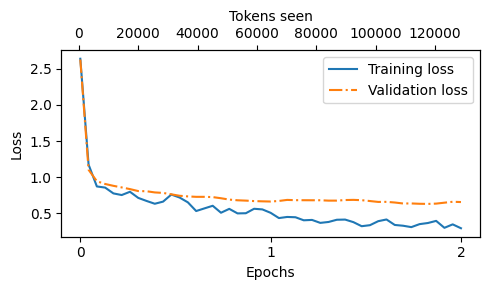

In [41]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Evaluate results

In [42]:
from previous_chapters import generate

torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(model = model, 
                         idx = text_to_token_ids(input_text, tokenizer).to(device),
                         max_new_tokens = 256, 
                         context_size = BASE_CONFIG["context_length"], 
                         eos_id = 50256)
    generated_text = token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer)
    resonse_text = (generated_text[len(input_text):].replace("### Response:", "").strip())
    print(input_text)
    print(f"\nCorrect response: \n>>{entry['output']}")
    print(f"\nModel response: \n>>{resonse_text.strip()}")
    print("-------------------------------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response: 
>>The car is as fast as lightning.

Model response: 
>>The car is as fast as a bullet.
-------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response: 
>>The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response: 
>>The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response: 
>>Jane Austen.



### Save responses to the test set and model

In [46]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    # Convert to token ids
    token_ids = generate(model=model, 
                         idx=text_to_token_ids(input_text, tokenizer=tokenizer).to(device), 
                         max_new_tokens=256, 
                         context_size=BASE_CONFIG["context_length"], 
                         eos_id=50256)
    generated_text = token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer)
    response_text = (
        generated_text[len(input_text):].replace("### Response:","").strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [08:38<00:00,  4.72s/it]


In [51]:
test_data[10]

{'instruction': 'What is the capital of Denmark?',
 'input': '',
 'output': 'The capital of Denmark is Copenhagen.',
 'model_response': 'The capital of Denmark is Copenhagen.'}

In [48]:
import re

In [49]:
filename = f"{re.sub(r'[ ()]','',CHOOSE_MODEL)}-sft.pth"
filename

'gpt2-medium355M-sft.pth'

In [50]:
torch.save(model.state_dict(), filename)
print("Model has been saved")

Model has been saved


## Evaluation the fine-tuned LLM

We use ollama phi3 for evaluation of out finetuned model
</br>
To run ollama or phi model, run: ollama run phi3

In [52]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama is not running. Lunch ollama before proceeding")

In [ ]:
import urllib.request

def query_model(prompt, 
                model = "phi3", # Its smaller for 8GB, otherwise use llama3
                url="http://localhost:11434/api/chat"):
    pass

SyntaxError: expected ':' (3844165512.py, line 6)